<img src="https://drive.google.com/uc?export=view&id=1JIIlkTWa2xbft5bTpzhGK1BxYL83bJNU" width="800"/>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ⚡️ `torch-nos` ⚡️: Nitrous Oxide System for PyTorch

**NOS** is a PyTorch library for optimizing and running lightning-fast inference of popular computer vision models. NOS inherits its name from "Nitrous Oxide System", the performance-enhancing system typically used in racing cars. NOS is designed to be modular and easy to extend.

## Why NOS?
- ⚡️ **Fast**: Built for PyTorch and designed to optimize/run models faster
- 🔥 **Performant**: Run models such as SDv2 or object detection 2-3x faster out-of-the-box
- 👩‍💻 **No PhD required**: Optimize models for maximum HW performance without a PhD in ML
- 📦 **Extensible**: Easily add optimization and HW-support for custom models
- ⚙️ **HW-accelerated:** Take full advantage of your HW (GPUs, ASICs) without compromise
- ☁️ **Cloud-agnostic:** Run on any cloud HW (AWS, GCP, Azure, Lambda Labs, On-Prem)

## Batteries Included
 - 💪 **SOTA Model Support:** NOS provides out-of-the-box support for popular CV models such as [Stable Diffusion](stabilityai/stable-diffusion-2), [OpenAI CLIP](openai/clip-vit-base-patch32), [OpenMMLab](https://github.com/open-mmlab/) object detection, tracking and more
 - 🔌 **APIs:** NOS provides out-of-the-box APIs and avoids all the ML model deployment hassles
 - 🐳 **Docker:** NOS ships with docker images to run accelerated and scalable CV workloads
 - 📈 **Multi-Platform**: NOS allows you to run models on different HW (NVIDIA, custom ASICs) without any model compilation or runtime management.

## Installation

NOS is available on PyPI and can be installed via pip. We recommend using a virtual environment or conda to install NOS:

```bash
$ conda create -n nos-py38 python=3.8
$ conda activate nos-py38
$ pip install torch-nos
```

Alternatively, if you want to install the entirety of NOS with its server-side dependencies, you can install NOS with the `server` and `gpu` extra:

```bash
$ pip install torch-nos[server,gpu]
```

The tutorial below assumes that you have only installed the vanilla `torch-nos` package.

## NOS Runtime

NOS operates as a client-server system. The NOS server is responsible for optimizing and running the model. The NOS client is responsible for sending inference requests to the NOS server. 

In [3]:
import nos

# Start the nos server backend
nos.init(runtime="auto")

2023-11-10 12:45:13.174 | INFO     | nos.server:_pull_image:227 - Found up-to-date server image: autonomi/nos:0.1.0rc3-gpu
2023-11-10 12:45:13.176 | INFO     | nos.server:init:161 - Starting inference service: [name=nos-inference-service-gpu, runtime=InferenceServiceRuntime(image=autonomi/nos:0.1.0rc3-gpu, name=nos-inference-service-gpu, device=gpu)]
2023-11-10 12:45:13.516 | INFO     | nos.server:init:188 - Inference service started: [name=nos-inference-service-gpu, runtime=InferenceServiceRuntime(image=autonomi/nos:0.1.0rc3-gpu, name=nos-inference-service-gpu, device=gpu), image=<Image: 'autonomi/nos:0.1.0rc3-gpu'>, id=fb40573e481a]


<Container: fb40573e481a>

To double-check if your nos server has started successfully, you can run `docker ps | grep nos` to check the status of your server.

In [4]:
!docker ps | grep nos

fb40573e481a   autonomi/nos:0.1.0rc3-gpu       "/app/entrypoint.sh"   2 seconds ago   Up 1 second   0.0.0.0:50051->50051/tcp, :::50051->50051/tcp   nos-inference-service-gpu


## Inference Client SDK

Once the NOS server is running, you can send inference requests using the NOS client SDK. 
Let's start by importing the NOS client SDK and creating a client instance. The client instance is used to send inference requests to the NOS server.

In [5]:
from nos.client import Client, TaskType

# Create a client that connects to the inference server via gRPC (50051)
client = Client()

In [6]:
# We provide helper functions to wait for the server to be ready
# if the server is simultaneously spun up in a separate process.
client.WaitForServer()

2023-11-10 12:45:17.940 | WARNING  | nos.client.grpc:WaitForServer:164 - Waiting for server to start... (elapsed=0s)


True

In [7]:
# Finally, we can check if the server is healthy.
client.IsHealthy()

True

## Run Inference

Now, we're ready to run inference using our client. First, let's load an image for inference. 

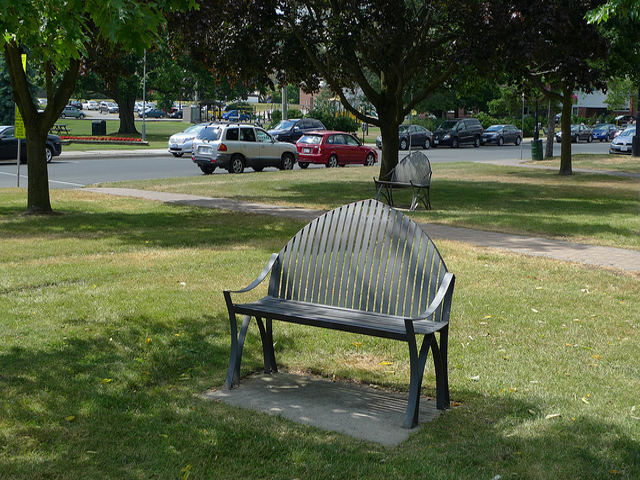

In [8]:
import requests
from PIL import Image


URL = "https://raw.githubusercontent.com/open-mmlab/mmdetection/main/demo/demo.jpg"
img = Image.open(requests.get(URL, stream=True).raw).resize((640, 480))
img

## `client.Module` Interface

NOS provides a convenient `client.Module` interface to get model handles for simpler remote-model execution. In this case, the following line re-uses the same `yolox/medium` model instantiated earlier as creates a handle called `yolox` that can be used by the client to get object detection results.  

### Run object detection with [YOLOX](https://github.com/Megvii-BaseDetection/YOLOX)

Here, we will use the `client.Module` API to run inference on the YOLOX object detection model. See the [`client.Module(...)`](https://docs.nos.run/docs/api/client/#nos.client.grpc.Client.Module) documentation for more details.

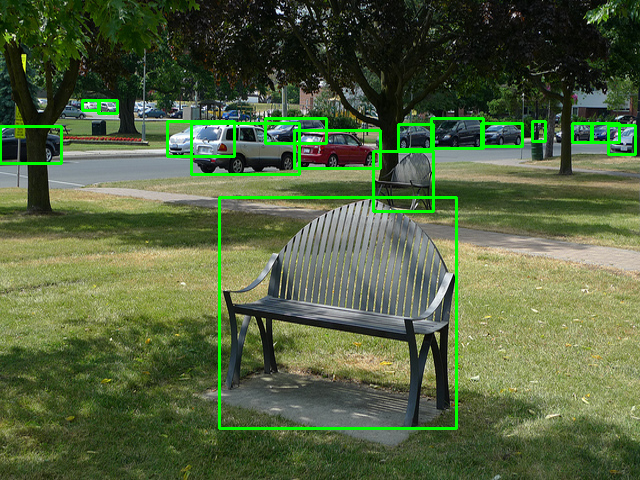

In [9]:
import cv2
import numpy as np


def visualize_bboxes(img: np.ndarray, bboxes: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """Visualize 2D detection results on an image."""
    vis = np.asarray(img).copy()
    for bbox, label in zip(bboxes.astype(np.int32), labels):
        cv2.rectangle(vis, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    return vis


# Initiaize the yolox model as a client Module
yolox = client.Module("yolox/medium")

# Run inference on the image just like a normal pytorch model
predictions = yolox(images=img)
for idx, (img, bboxes, scores, labels) in enumerate(zip([img], predictions["bboxes"], predictions["scores"], predictions["scores"])):
    display(Image.fromarray(visualize_bboxes(img, bboxes, labels)))

### Extract image-embedding with [OpenAI CLIP](https://huggingface.co/openai/clip-vit-base-patch32)

In [10]:
from PIL import Image
from nos.test.utils import NOS_TEST_IMAGE

img = Image.open(NOS_TEST_IMAGE)

clip = client.Module("openai/clip")
predictions = clip.encode_image(images=[img, img])
predictions["embedding"].shape

(2, 512)

### Extract text-embedding with [OpenAI CLIP](https://huggingface.co/openai/clip-vit-base-patch32)

In [14]:
predictions = clip.encode_text(texts=["cat", "dog"])
predictions["embedding"].shape

(2, 512)

 ### Text-to-image generation with [StableDiffusionV2](https://huggingface.co/stabilityai/stable-diffusion-2)

In [ ]:
prompts = ["fox jumped over the moon", "fox jumped over the sun"]

# Initialize the model as a client Module
sdv2 = client.Module("stabilityai/stable-diffusion-2")

# Run inference on the image just like a normal pytorch model
# predictions = sdv2(inputs={"prompts": prompts, "width": 512, "height": 512, "num_images": 1})
predictions = sdv2(prompts=prompts, width=512, height=512, num_images=1)

# Display the generated images
for prompt, image in zip(prompts, predictions["images"]):
    print(prompt, image.size)
    display(image)

### Depth prediction with [MiDaS](https://github.com/isl-org/MiDaS)

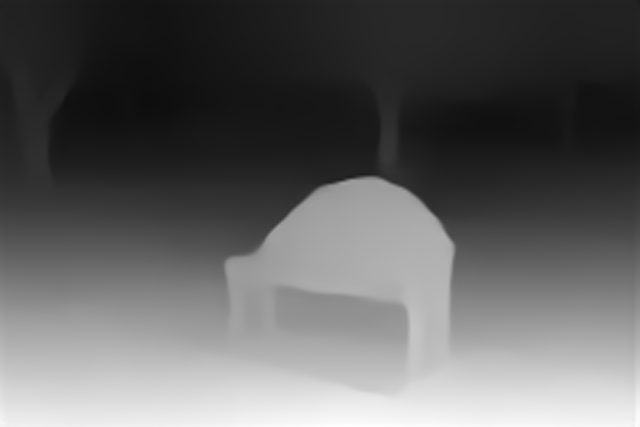

In [13]:
midas = client.Module("isl-org/MiDaS-small")
pred = midas(images=img)
pred = Image.fromarray((pred["depths"] * 255 / pred["depths"].max()).astype(np.uint8))
display(pred)
